In [1]:
import torch
import os
from torch import nn
import utils
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings

warnings.filterwarnings('ignore')

### Prepare MNIST dataset
For our project, we utilized the MNIST dataset. MNIST dataset includes images with digits 0-9 and the following block is responsible to download, extract split and form the dataset to train and test dataloaders. The ratio between train and test dataloaders is (80%-20%).

In [2]:
train_loader, test_loader = utils.prepare_dataset()

### Load pre-trained model
For this example, a well known deep learning model architecure called Lenet5 was selected. I have already trained the initial model over 10 epochs and in the following code block I loaded it.

In [3]:
 # create a model instance
model_fp32 = utils.LeNet5()
# Check saved model with 32 bits exists, otherwise train it
if not os.path.isfile("models/model_32.pth"):
    loss_func = nn.CrossEntropyLoss()
    losses = utils.train(model_fp32, train_loader, num_epochs=10)
    # Save weights
    torch.save(model_fp32.state_dict(), "models/model_32.pth")
else:
    # Load model
    model_fp32.load_state_dict(torch.load("models/model_32.pth"))

In the following code block, we run the inference part of the initial Lenet5 model 10 times to extract the mean accuracy, mean inference time and mean model size. Those metrics will be compared later with the quantization techniques results.

In [4]:
num_experiments = 10
results = []
avg_model_size, avg_time_evaluation, avg_accuracy = utils.calc_model_metrics(model_fp32, test_loader, num_experiments)
print('Model type: Original - Size (KB): {}'.format(avg_model_size))
print('''Accuracy: {}% - Elapsed time (seconds): {}'''.format(avg_accuracy, avg_time_evaluation))
results.append([avg_model_size, avg_time_evaluation, avg_accuracy])


Model type: Original - Size (KB): 249.89
Accuracy: 71.57% - Elapsed time (seconds): 0.69


### Experiment with Quantization Techniques
One technique to minimize the size of a ML model is quantitation. In particular, quantization refers to techniques for doing both computations and memory accesses with lower precision data. Theoretically, this technique affects as well inference time and accuracy. In this project, I implemented three techniques for quantizing neural networks in PyTorch as part of quantization tooling in the torch.quantization name-space. Below, I introduce all 3 of them, running experiments on the initial Lenet5 model we previously loaded. The experiments were executed 10 times and the mean accuracy, mean inference time and mean quantization model size were extracted and plotted.

In [5]:
# Start experiments with quantitation methods
torch.backends.quantized.engine = 'qnnpack'

#### Dynamic Quantitation
This method involves not just converting the weights to int8 - as happens in all quantization variants - but also converting the activations to int8 on the fly, just before doing the computation (hence “dynamic”). The computations will thus be performed using efficient int8 matrix multiplication and convolution implementations, resulting in faster compute. However, the activations are read and written to memory in floating point format.

In [6]:
  # Dynamic Quantitation
dquant_avg_model_size, dquant_avg_time_evaluation, dquant_avg_accuracy = utils.calc_dynamic_quant_metrics(model_fp32, test_loader, num_experiments)
print('Model type: Dynamic-Quantitation - Size (KB): {}'.format(dquant_avg_model_size))
print('''Accuracy: {}% - Elapsed time (seconds): {}'''.format(dquant_avg_accuracy, dquant_avg_time_evaluation))
results.append([dquant_avg_model_size, dquant_avg_time_evaluation, dquant_avg_accuracy])

[W qlinear_dynamic.cpp:247] Warning: Currently, qnnpack incorrectly ignores reduce_range when it is set to true; this may change in a future release. (function operator())


Model type: Dynamic-Quantitation - Size (KB): 75.07
Accuracy: 71.58% - Elapsed time (seconds): 0.72


#### Post-Training Static Quantization
Except for converting networks to use both integer arithmetic and int8 memory accesses, this method focuses on an additional step of first feeding batches of data through the network and computing the resulting distributions of the different activations (specifically, this is done by inserting “observer” modules at different points that record these distributions). This information is used to determine how specifically the different activations should be quantized at inference time. Importantly, this additional step allows us to pass quantized values between operations instead of converting these values to floats - and then back to ints - between every operation, resulting in a significant speed-up.

In [7]:
# Post-Training Static Quantization
quantitation_method = 'x86'
stat_quant_avg_model_size, stat_quant_avg_time_evaluation, stat_quant_avg_accuracy = utils.calc_post_training_static_quant_metrics(model_fp32, test_loader, quantitation_method, num_experiments)
print('Model type: Static-Quant - Size (KB): {}'.format(stat_quant_avg_model_size))
print('''Accuracy: {}% - Elapsed time (seconds): {}'''.format(stat_quant_avg_accuracy, stat_quant_avg_time_evaluation))
results.append([stat_quant_avg_model_size, stat_quant_avg_time_evaluation, stat_quant_avg_accuracy])


Model type: Static-Quant - Size (KB): 74.97
Accuracy: 71.57% - Elapsed time (seconds): 0.74


#### Quantization-aware training (QAT)
QAT is the last one quantization technique that typically results in highest accuracy of these three. With QAT, all weights and activations are “fake quantized” during both the forward and backward passes of training: that is, float values are rounded to mimic int8 values, but all computations are still done with floating point numbers. Thus, all the weight adjustments during training are made while “aware” of the fact that the model will ultimately be quantized; after quantizing, therefore, this method usually yields higher accuracy than the other two methods.

In [8]:
# Quantization Aware Training
quant_aware_avg_model_size, quant_aware_avg_time_evaluation, quant_aware_avg_accuracy = utils.calc_quant_aware_training_metrics(model_fp32, train_loader, test_loader, quantitation_method,
                                                                                                                                num_experiments)
print('Model type: Quant Aware Training (QAT) - Size (KB): {}'.format(quant_aware_avg_model_size))
print('''Accuracy: {}% - Elapsed time (seconds): {}'''.format(quant_aware_avg_accuracy, quant_aware_avg_time_evaluation))
results.append([quant_aware_avg_model_size, quant_aware_avg_time_evaluation, quant_aware_avg_accuracy])


Model type: Quant Aware Training (QAT) - Size (KB): 74.97
Accuracy: 71.65% - Elapsed time (seconds): 0.75


Print all results from our experiments in a dataframe format.

In [9]:
df = pd.DataFrame(results, columns=['model_size', 'inference_time', 'accuracy'], index=["Original", "DQuant", "PT Static Quant", "QAT"])
print(df)

                 model_size  inference_time  accuracy
Original             249.89            0.69     71.57
DQuant                75.07            0.72     71.58
PT Static Quant       74.97            0.74     71.57
QAT                   74.97            0.75     71.65


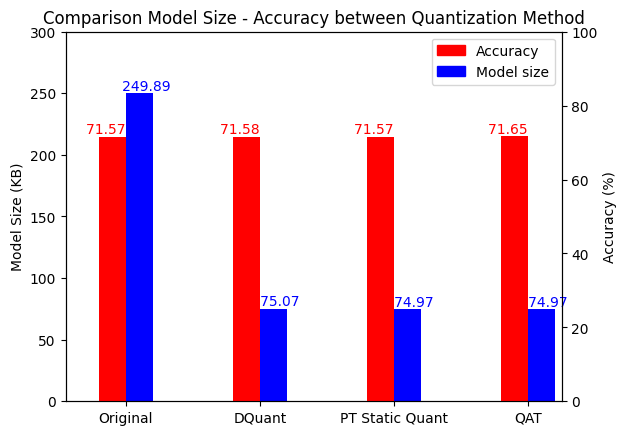

In [10]:
df = df[['model_size', 'accuracy']].copy()
# Create matplotlib figure
fig = plt.figure()
# Create matplotlib axes
ax = fig.add_subplot(111)
# Create another axes that shares the same x-axis as ax.
ax2 = ax.twinx()
width = 0.2
df.model_size.plot(kind='bar', color='blue', ax=ax, width=width, position=0)
df.accuracy.plot(kind='bar', color='red', ax=ax2, width=width, position=1)
# Create custom legend for 2 yaxis
blue_patch = mpatches.Patch(color='blue', label='Model size')
red_patch = mpatches.Patch(color='red', label='Accuracy')
plt.legend(handles=[red_patch, blue_patch])
for bars in ax.containers:
    ax.bar_label(bars, labels=['   %.2f' % value for value in bars.datavalues], color='b', fontsize=10)
for bars in ax2.containers:
    ax2.bar_label(bars, labels=['%.2f   ' % value for value in bars.datavalues], color='r', fontsize=10)
# Set y labels, axis limits, rotation x-axis, and figure title
ax.set_ylabel('Model Size (KB)')
ax.set_ylim(0, 300)
ax2.set_ylabel('Accuracy (%)')
ax2.set_ylim(0, 100)
ax.xaxis.set_tick_params(rotation=0)
plt.title("Comparison Model Size - Accuracy between Quantization Method")
plt.show()

As we can see from the figure above, all quantization methods drop significantly their model size, up to 3.3 times smaller. In the meantime, we observe that the accuracy remains constant for all approaches, and in some cases it might slightly improve. Thanks to bibliography, this is still possible.